# Script for baseline OLS of WASO

## Imports

In [84]:
##Generic imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [85]:
##Script specific imports for feature encoding

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

In [86]:
file = r'/Users/anand/Documents/Sleep/WSC - variable cross-check_v1.xlsx'
data = r'/Users/anand/Documents/Sleep/wsc-dataset-0.2.0.csv'

In [149]:
df = pd.read_excel(file)
data_df = pd.read_csv(data)

In [439]:
pd.set_option('display.max_columns', None)
data_df.head()

,wsc_vst,sex,age,race,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,uric_acid,heightcm,weightkg,bmi,headcm,waist_girth1,waist_girth2,hip_girth1,hip_girth2,neck_girth1,neck_girth2,sit_sys1,sit_dia1,sit_sys2,sit_dia2,p_eval_sleep,a_eval_slept,a_eval_hour,a_eval_sleep,hipgirthm,neckgirthm,waistgirthm,waisthip,sitsysm,sitdiam,ess,zung_score,zung_index,state,trait,cans_cola,cups_coffee,caffeine,beer_week,wine_week,hard_week,nondrinker,alcohol_wk,smoke,smoke_curr,bowls_day,packs_week,cigars_day,smoke_quit,smoke_years,pack_years,eval_general,eval_life,eval_health,tso,workday,weekend,totsleep,naps,sleepiness,ps_eds,anyinsomnia,snore_freq,snore_vol,choke_freq,apnea_freq,awake_freq,nasal_cong_none,coronary_ynd,angina_ynd,arrhythmia_ynd,heartattack_ynd,coronarybypass_ynd,any_cvd,hypertension_ynd,diabetes_ynd,asthma_ynd,thyroid_ynd,arthritis_ynd,apnea,angioplasty_ynd,ho_score,menopausal_status,num_pregnancies,asthma_med,asthma_rescue_med,asthma_control_med,cholesterol_med,depression_med,dep_ssri_med,htn_med,htn_acei_med,htn_alpha_med,htn_arb_med,htn_beta_med,htn_diuretic_med,decongestants_med,antihistamines_med,anxiety_med,diabetes_med,estrogen_med,progesterone_med,sedative_med,thyroid_med,psg_cpap,tst,tst_rem,tst_nrem,ahi,minsao2tst,ptstl90,se,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,5,6.0,0.9,89.0,52.0,149.0,228.0,137.0,7.2,176,85.5,27.6,59.5,92.0,92.0,97.0,96.5,39.5,39.5,112.0,78.0,116.0,80.0,3.0,2.0,7.0,3.0,96.8,39.5,92.0,0.9509,114.0,79.0,2.0,24.0,30.00,20.0,24.0,1,3,4,2.0,0.0,0.0,0.0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,1,1,4.0,7.5,8.0,7.6,0.0,0.0,0,0,2.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,69,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,368.0,38.5,329.5,0.5,93.8,0.0,83.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5,5.0,0.8,96.0,77.0,122.0,222.0,117.0,3.4,170,73.0,25.3,54.9,81.0,81.0,107.0,107.0,31.5,31.5,132.0,84.0,132.0,84.0,2.0,2.0,7.5,3.0,107.0,31.5,81.0,0.7570,132.0,84.0,7.0,31.0,38.75,27.4,24.0,4,0,4,1.0,0.0,0.0,0.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,2,2,13.0,6.5,10.5,7.6,0.0,0.0,1,0,1.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,NaN,419.0,129.0,290.0,0.0,94.2,0.0,87.1,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,5,4.0,0.9,103.0,48.0,146.0,211.0,85.0,5.9,157,115.5,46.9,56.7,143.0,143.0,147.5,147.5,39.5,39.5,142.0,88.0,146.0,92.0,3.0,2.0,4.0,3.0,147.5,39.5,143.0,0.9695,144.0,90.0,6.0,30.0,37.50,25.3,28.0,0,0,0,NaN,NaN,NaN,1.0,0,1,0.0,NaN,11.0,NaN,1986.0,30.0,47.142857,1,1,3,13.0,6.5,9.0,7.2,1.0,0.0,1,0,9.0,9,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,67,4.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1.0,384.0,69.5,314.5,7.3,87.2,0.7,83.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,5,4.0,1.4,131.0,39.0,107.0,173.0,135.0,8.5,173,79.2,26.5,56.8,98.0,98.0,99.5,99.5,39.5,39.0,128.0,76.0,132.0,78.0,5.0,2.0,5.0,3.0,99.5,39.3,98.0,0.9849,130.0,77.0,0.0,34.0,42.50,37.9,36.0,0,6,6,42.0,0.0,0.0,NaN,42,1,1.0,NaN,13.0,NaN,NaN,42.0,78.000000,1,3,3,5.0,7.0,9.0,7.6,0.0,0.0,0,0,5.0,4,2,9,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,57,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,328.0,46.5,281.5,18.1,89.8,0.0,71.4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,1,4.0,0.9,102.0,37.0,135.0,228.0,281.0,7.1,171,100.6,34.4,57.7,113.0,113.0,111.5,112.0,42.0,42.0,140.0,88.0,142.0,90.0,7.0,3.0,4.5,4.0,111.8,42.0,113.0,1.0112,141.0,89.0,7.0,31.0,38.75,21.1,25.0,1,0,1,NaN,NaN,NaN,1.0,0,1,0.0,NaN,2.0,NaN,1974.0,4.0,1.142857,2,1,5,4.0,5.5,6.5,5.8,8.0,1.0,2,0,4.0,2,9,9,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,62,1.0,2.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,350.5,47.0,303.5,18.3,84.8,2.0,81.6,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [150]:
deleted = df[df['Proposed Removal'] == 'R']
deleted_cols = deleted.iloc[:, 0]
#deleted_cols.to_list()

In [151]:
data_df = data_df.drop(deleted_cols.to_list(), axis=1)

In [152]:
## sort out nasal_cong_none
data_df.nasal_cong_none.replace({np.nan:0,'Y':1}, inplace=True)

## Balancing

In [153]:
##BALANCING

balance_cutoff = 0.975
imbalanced_classes = []
for col in data_df.columns:
    _ = data_df.columns.get_loc(col)
    if data_df.iloc[:, _].value_counts(normalize=True).head(1).values > balance_cutoff:
        imbalanced_classes.append((col, data_df.iloc[:, _].value_counts(normalize=True).head(1).values.astype(float)))

In [154]:
imbalanced_classes

[('atheroscl_ynd', array([0.9758661])),
 ('congestivehf_ynd', array([0.98871595])),
 ('stroke_ynd', array([0.97743191])),
 ('emphysema_ynd', array([0.97898833])),
 ('pacemaker_ynd', array([0.99105058])),
 ('coronary_artery_stent_ynd', array([0.9766537])),
 ('dep_maoi_med', array([0.99922179])),
 ('dep_tca_med', array([0.9766537])),
 ('narcotics_med', array([0.9766537])),
 ('androgen_med', array([0.99688716])),
 ('stimulants_med', array([0.9848249])),
 ('psg_oxygen', array([1.]))]

In [155]:
imbalanced_list = []
for classes in imbalanced_classes:
    imbalanced_list.append(classes[0])

In [156]:
imbalanced_list

['atheroscl_ynd',
 'congestivehf_ynd',
 'stroke_ynd',
 'emphysema_ynd',
 'pacemaker_ynd',
 'coronary_artery_stent_ynd',
 'dep_maoi_med',
 'dep_tca_med',
 'narcotics_med',
 'androgen_med',
 'stimulants_med',
 'psg_oxygen']

## Removal of serial observations

In [157]:
##DUPLICATES

data_df.drop(imbalanced_list, axis=1, inplace=True)
data_df.drop_duplicates('wsc_id', inplace=True)
data_df.set_index('wsc_id', inplace=True)
#data_df.fillna(0, inplace=True)

## Feature encoding

In [158]:
objlist = []

for n in data_df.dtypes[data_df.dtypes == 'object'].index:
    objlist.append(n)

In [159]:
## Binariser -  should work if nans are present or not...

for i,v in enumerate(objlist):
    
    ##columns with 2 variables eg. [N,Y] or [M,F]
    
    if len(data_df[v].unique()) == 2:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({data_df[objlist[i]].unique()[0]:0,data_df[objlist[i]].unique()[1]:1}, inplace=True)
        
    #### ALL columns with 3 variables - which appear like [N,Y,nan]
    if len(data_df[v].unique()) == 3:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({'N':0,'Y':1}, inplace=True)

In [160]:
#### ONE HOT ENCODER SCRIPT

ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)


## Only variables which need OHE
X1 = data_df[['thyroid_problem']]
X2 = data_df[['hormone_therapy']]

##fit transform, extract column names, make dataframe with column names, drop nan row

X1t = ohe.fit_transform(X1)
colnames = list(ohe.get_feature_names())
X1df = pd.DataFrame(X1t, columns = colnames)
X1df.drop(columns = 'x0_nan', inplace=True)
X1df.index = data_df.index

X2t = ohe.fit_transform(X2)
colnames = list(ohe.get_feature_names())
X2df = pd.DataFrame(X2t, columns = colnames)
X2df.drop(columns = 'x0_nan', inplace=True)
X2df.index = data_df.index

frames = [data_df, X1df, X2df]
data_df = pd.concat(frames, axis = 1)

##drop original row names

data_df.drop(columns = ['thyroid_problem','hormone_therapy'], inplace=True)

In [298]:
data_df.head()

,wsc_vst,sex,age,race,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,...,se,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,5,6.0,0.9,89.0,52.0,149.0,228.0,...,83.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5,5.0,0.8,96.0,77.0,122.0,222.0,...,87.1,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,5,4.0,0.9,103.0,48.0,146.0,211.0,...,83.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,5,4.0,1.4,131.0,39.0,107.0,173.0,...,71.4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,1,4.0,0.9,102.0,37.0,135.0,228.0,...,81.6,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [220]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso

## Target Selection

In [ ]:
## First targets = waso, tst, se, tso

In [382]:
#### Keep main target (WAS0)
y = data_df.waso
y.shape

(1123,)

In [307]:
#### Other confounding targets to remove including target

targs = ['tst', 'tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds','se', 'waso','sleepiness']

In [383]:
## Drop confounding targets

X = data_df.drop(columns = targs)
X.shape

(1123, 113)

In [309]:
#### Scaling numerical features - categorical features and targets removed from this listt

numeric_features = ['creatinine', 'glucose', 'hdl', 'ldl','total_cholesterol', 'triglycerides', 'uric_acid', 'weightkg', 'bmi',
       'headcm', 'waist_girth1', 'waist_girth2', 'hip_girth1', 'hip_girth2',
       'neck_girth1', 'neck_girth2', 'sit_sys1', 'sit_dia1', 'sit_sys2',
       'sit_dia2', 'hipgirthm', 'neckgirthm', 'waistgirthm', 'waisthip',
       'sitsysm', 'sitdiam', 'zung_score', 'zung_index', 'state',
       'trait', 'beer_week', 'wine_week', 'hard_week', 'bowls_day', 'packs_week', 'cigars_day',
       'smoke_years', 'pack_years','workday', 'weekend',
       'naps', 'snore_freq',
       'num_pregnancies', 'psg_cpap', 'ahi',
       'minsao2tst', 'ptstl90', 'age', 'heightcm', 'cans_cola', 'cups_coffee',
       'caffeine', 'alcohol_wk','eval_general', 'eval_life','eval_health', 
       'snore_vol', 'choke_freq',
       'apnea_freq', 'awake_freq', 'ho_score']

In [314]:
len(categorical_features)

52

In [311]:
len(numeric_features)

61

In [167]:
#### Ordinal variables to be aware of - should not be scaled
ords = ['menopausal_status']


## Column transforming

In [312]:
categoric = data_df.drop(columns = targs)
categoric.drop(columns = numeric_features, inplace=True)
#categoric.drop(columns =['waso', 'wsc_vst'], inplace=True)

In [313]:
categorical_features = categoric.columns

In [315]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

In [316]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

In [317]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),\
        ('cat', categorical_transformer, categorical_features)])

In [318]:
prepipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [275]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),('regression', LinearRegression())])

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [385]:
cv_results = cross_validate(pipe, X_train, y_train, cv=10, scoring=('r2','neg_mean_absolute_error'))
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_neg_mean_absolute_error', 'test_r2']

In [386]:
cv_results['test_neg_mean_absolute_error'].mean()

-30.894803901881083

In [387]:
cv_results['test_r2'].mean()

-0.07154605958841398

In [280]:
y_train.min(), y_train.max()

(3.0, 291.5)

# VIF

In [292]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [338]:
Xt = prepipe.fit_transform(X_train)

In [324]:
X_train.columns

Index(['wsc_vst', 'sex', 'age', 'race', 'education_survey1', 'creatinine',
       'glucose', 'hdl', 'ldl', 'total_cholesterol',
       ...
       'ptstl90', 'waso', 'x0_Hyperthyroid', 'x0_Hypothyroid', 'x0_Nodule',
       'x0_Thyroid Cancer', 'x0_Unknown', 'x0_C', 'x0_N', 'x0_P'],
      dtype='object', length=114)

In [365]:
X_train.shape

(898, 113)

In [366]:
Xt.shape

(898, 113)

In [293]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [368]:
vifs = calc_vif(Xt1)

/Users/anand/.pyenv/versions/3.8.6/envs/dreamteam/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/anand/.pyenv/versions/3.8.6/envs/dreamteam/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [380]:
vifs.sort_values(by='VIF', ascending=False, inplace=True)

In [381]:
vifs.head(30)

,variables,VIF
51,smoke_years,inf
109,x0_Thyroid Cancer,inf
52,pack_years,inf
28,neckgirthm,inf
81,num_pregnancies,inf
110,x0_Unknown,inf
27,hipgirthm,inf
106,x0_Hyperthyroid,inf
107,x0_Hypothyroid,inf
108,x0_Nodule,inf


# Statsmodels OLS

In [ ]:
#using statsmodels - needs preprocessed dataframe without NaNs

import statsmodels.api as sm

##Needs a constant inserted

X.insert(loc=0, column='constant', value=1)

##Modelling

model = sm.OLS(y, X)

result = model.fit()

result.summary()

In [333]:
import statsmodels.api as sm

In [339]:
Xt.shape

(898, 113)

In [342]:
Xt1 = pd.DataFrame(Xt, columns = X_train.columns)

In [356]:
#Xt1.insert(loc=0, column='constant', value=1)

In [357]:
Xt1

,constant,wsc_vst,sex,age,race,education_survey1,creatinine,glucose,hdl,ldl,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
0,1,0.009159,0.271868,-0.504414,-0.880865,-0.599595,0.736591,-0.037890,-0.758256,-0.808969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.981721,-0.157088,-0.096474,1.270407,1.334357,0.540703,3.212830,0.965662,0.627979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.009159,-0.586045,-0.776374,-0.662620,-0.980937,-0.242847,1.695827,-0.719733,-0.488097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.495440,-0.085596,-0.844364,1.644541,1.116447,0.033700,-0.471319,0.113334,-0.083519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-0.963402,-0.657537,0.311466,0.023293,-0.327207,-1.026397,-0.254605,-0.743810,-1.143792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,1,-1.935963,2.845605,-0.028484,-0.413197,0.217568,1.243594,-0.760272,0.219273,0.348960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
894,1,0.009159,-0.621791,1.195336,-1.442066,-1.198847,-0.899646,-1.988322,-1.080889,-1.004282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
895,1,0.495440,-0.764776,0.583426,1.145696,1.007492,-0.484826,-0.976987,-1.249428,-1.464664,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
896,1,0.009159,-0.300074,-1.048334,-0.724975,-1.335041,-0.611576,0.828969,0.556352,0.181549,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [346]:
yt = y_train.reset_index(drop=True)

In [435]:
model = sm.OLS(yt, Xt1)

In [436]:
result = model.fit()

In [425]:
pvals = pd.DataFrame(result.pvalues).sort_values(by = 0, ascending=True)

In [437]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   waso   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     2.732
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           1.53e-15
Time:                        15:54:29   Log-Likelihood:                -4457.1
No. Observations:                 898   AIC:                             9134.
Df Residuals:                     788   BIC:                             9662.
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
constant            -119.7995    231.703     -0.517      0.605    -574.628     335.029
wsc_vst               -0.6246      1.603     -0.390      0.697      -3.771       2.522
sex                   -0.9136      1.672     -0.546      0.585      -4.195       2.368
age                   -1.6522      3.357     -0.492      0.623      -8.241       4.937
race                  -1.8236      6.913     -0.264      0.792     -15.393      11.746
education_survey1      4.3343      7.685      0.564      0.573     -10.752      19.421
creatinine            -0.2474      3.449     -0.072      0.943      -7.017       6.522
glucose               -0.3705      1.748     -0.212      0.832      -3.801       3.060
hdl                  -21.7887     13.958     -1.561      0.119     -49.188       5.610
ldl                   33.0041     14.200      2.324      0.020       5.130      60.878
total_cholesterol      0.3747      1.972      0.190      0.849      -3.497       4.247
triglycerides        -21.0386    144.981     -0.145      0.885    -305.634     263.557
uric_acid             80.2057     94.604      0.848      0.397    -105.499     265.911
heightcm              57.7668    138.209      0.418      0.676    -213.535     329.068
weightkg             -53.4107     28.075     -1.902      0.057    -108.521       1.699
bmi                   61.4012    129.713      0.473      0.636    -193.222     316.024
headcm                78.8251    141.820      0.556      0.578    -199.565     357.216
waist_girth1           4.1035     14.109      0.291      0.771     -23.593      31.800
waist_girth2           7.2802     11.450      0.636      0.525     -15.195      29.756
hip_girth1             8.9472     14.570      0.614      0.539     -19.653      37.547
hip_girth2            10.2626     11.530      0.890      0.374     -12.372      32.897
neck_girth1          -23.8596    146.415     -0.163      0.871    -311.270     263.551
neck_girth2         -141.6260    267.510     -0.529      0.597    -666.743     383.491
sit_sys1             -45.8483    217.254     -0.211      0.833    -472.313     380.616
sit_dia1             -14.1093     12.361     -1.141      0.254     -38.374      10.155
sit_sys2             -11.9846     27.068     -0.443      0.658     -65.119      41.150
sit_dia2             -15.1142     21.389     -0.707      0.480     -57.101      26.872
hipgirthm             -1.7270      1.138     -1.517      0.130      -3.961       0.507
neckgirthm            -1.7270      1.138     -1.517      0.130      -3.961       0.507
waistgirthm           -0.4027      1.884     -0.214      0.831      -4.102       3.296
waisthip               4.2778      2.475      1.728      0.084      -0.581       9.136
sitsysm               11.4711     10.829      1.059      0.290      -9.786      32.729
sitdiam                5.3531      5.7

In [426]:
pvals.head(20)

,0
packs_week,1.672029e-11
smoke,2.581258e-05
coronarybypass_ynd,2.545399e-04
arthritis_ynd,7.453744e-03
ldl,2.036480e-02
cigars_day,2.268720e-02
smoke_curr,4.123981e-02
cholesterol_med,4.829704e-02
weightkg,5.747719e-02
asthma_ynd,6.066485e-02


In [388]:
lin = LinearRegression()

In [389]:
lin.fit(Xt1,yt)

LinearRegression()

In [407]:
Xtest1.insert(loc=0, column='constant', value=1)

In [408]:
Xtest1.shape

(225, 114)

In [409]:
ypred = lin.predict(Xtest1)

In [412]:
r2_score(ytest, ypred)

0.15985970132440386

In [395]:
Xtest = prepipe.fit_transform(X_test)
Xtest1 = pd.DataFrame(Xtest, columns = X_test.columns)

In [410]:
from sklearn.metrics import mean_squared_error, r2_score

In [401]:
ytest.shape

(225,)

In [398]:
ytest = y_test.reset_index(drop=True)

In [396]:
Xtest1

,wsc_vst,sex,age,race,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
0,1.341034,0.054003,0.059422,-0.431069,-0.389992,-0.116512,0.397010,1.416740,2.555649,-0.621804,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.400413,-0.322723,1.730909,0.488504,0.849095,-0.546480,-0.647312,-0.306977,0.599940,-1.297460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.470311,-0.322723,-1.194193,0.000000,-0.812408,1.708230,1.310792,-0.376857,-0.803069,-0.171366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.400413,0.273760,-0.149514,0.422820,0.764612,0.837807,0.397010,0.620103,0.982579,-0.441629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.470311,-0.322723,-0.497740,-0.102650,-0.474475,-0.378687,-0.843123,-0.190509,-0.533805,0.053852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,-0.400413,-0.291329,-0.428095,-0.989381,-1.319308,-0.619889,-0.777853,-0.120629,-0.278712,0.504290,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,0.470311,-0.228541,-0.079868,1.046816,0.961740,0.114203,1.376062,0.927577,1.336874,-0.621804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
222,-1.271137,-0.354116,2.218426,-0.923698,-0.221026,-0.672324,-1.691635,-0.959194,-0.888100,-0.847023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223,2.647120,-0.228541,-1.821000,0.061559,-0.361831,0.575632,0.592821,0.578175,-0.321228,2.306040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

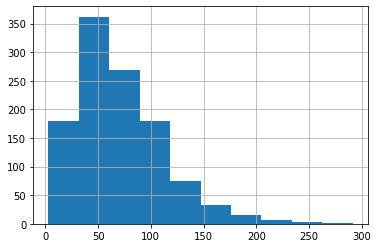

In [397]:
data_df.waso.hist()

# Sparse model

In [427]:
sparse = ['sex', 'age', 'x0_Hyperthyroid','x0_Hypothyroid', 'heightcm', 'weightkg', 'neck_girth1', 'zung_score', 'state', 'trait', 'caffeine', 'smoke', 'snore_freq', 'any_cvd', 'asthma_ynd', 'apnea', 'arthritis_ynd', 'neckgirthm' ]

In [429]:
Xs = Xt1[sparse]

In [430]:
yt

0       67.5
1       37.0
2       39.5
3       35.0
4      112.0
       ...  
893    243.0
894    141.5
895     35.0
896     43.5
897     97.5
Name: waso, Length: 898, dtype: float64

In [431]:
Xs

,sex,age,x0_Hyperthyroid,x0_Hypothyroid,heightcm,weightkg,neck_girth1,zung_score,state,trait,caffeine,smoke,snore_freq,any_cvd,asthma_ynd,apnea,arthritis_ynd,neckgirthm
0,0.271868,-0.504414,0.0,0.0,-1.115471,-1.151443,-1.131126,-0.519446,2.570678e-16,-6.000137e-16,-0.022286,-0.255142,-0.374701,1.0,0.0,0.0,0.0,-1.509097
1,-0.157088,-0.096474,0.0,0.0,0.052925,0.052239,0.050707,-0.519446,2.570678e-16,-6.000137e-16,-0.507788,0.111066,-0.374701,1.0,0.0,0.0,0.0,-0.485073
2,-0.586045,-0.776374,0.0,0.0,-0.668732,-0.669970,-0.670761,0.000000,2.570678e-16,-6.000137e-16,0.463217,-0.717720,-0.374701,0.0,1.0,0.0,0.0,-0.631362
3,-0.085596,-0.844364,0.0,0.0,-0.290721,-0.291670,-0.292849,-0.519446,-4.980024e-01,-6.000137e-16,-0.993291,0.727837,0.081855,0.0,1.0,0.0,0.0,-0.192494
4,-0.657537,0.311466,0.0,0.0,-1.252930,-1.254615,-1.254806,0.000000,2.570678e-16,-6.000137e-16,-0.022286,-0.036702,-0.374701,1.0,0.0,0.0,0.0,-0.631362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2.845605,-0.028484,0.0,0.0,0.671487,0.740057,0.703464,0.000000,2.570678e-16,-6.000137e-16,0.948720,-0.550678,-0.374701,0.0,0.0,0.0,0.0,-0.046205
894,-0.621791,1.195336,0.0,0.0,-0.565638,-0.566797,-0.567694,0.506460,2.570678e-16,-6.000137e-16,-0.022286,-0.749844,-0.374701,0.0,0.0,0.0,0.0,-0.631362
895,-0.764776,0.583426,0.0,1.0,-1.115471,-1.117052,-1.117384,-0.519446,8.086280e-02,-6.000137e-16,0.463217,-0.698446,-0.374701,1.0,0.0,0.0,0.0,1.416686
896,-0.300074,-1.048334,0.0,0.0,0.121654,0.121021,0.119418,-0.519446,2.570678e-16,-6.000137e-16,-0.022286,2.764465,0.081855,1.0,0.0,0.0,0.0,0.100084


In [432]:
##Needs a constant inserted

Xs.insert(loc=0, column='constant', value=1)

##Modelling

model = sm.(yt, Xs)

result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   waso   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.525
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           1.51e-09
Time:                        15:44:36   Log-Likelihood:                -4561.3
No. Observations:                 898   AIC:                             9161.
Df Residuals:                     879   BIC:                             9252.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
constant           70.7645      2.379     29.747      0.000      66.096      75.434
sex                 1.5294      1.414      1.082      0.280      -1.245       4.304
age                -1.3375      1.368     -0.977      0.329      -4.023       1.348
x0_Hyperthyroid     0.8253     14.073      0.059      0.953     -26.795      28.446
x0_Hypothyroid      2.7414      5.090      0.539      0.590      -7.249      12.732
heightcm           62.0109    139.606      0.444      0.657    -211.989     336.011
weightkg          -30.6788     26.090     -1.176      0.240     -81.885      20.527
neck_girth1       -34.3891    146.519     -0.235      0.814    -321.956     253.178
zung_score          0.5862      1.333      0.440      0.660      -2.030       3.202
state               1.1333      1.336      0.849      0.396      -1.488       3.755
trait               0.0997      1.324      0.075      0.940      -2.498       2.698
caffeine            3.3646      1.322      2.545      0.011       0.769       5.960
smoke               8.4682      1.406      6.023      0.000       5.709      11.228
snore_freq         -1.7687      1.337     -1.323      0.186      -4.393       0.856
any_cvd            -1.1669      2.798     -0.417      0.677      -6.659       4.325
asthma_ynd         -4.9309      4.037     -1.221      0.222     -12.855       2.993
apnea              -4.5213      5.692     -0.794      0.427     -15.692       6.649
arthritis_ynd      31.9046      8.548      3.733      0.000      15.129      48.681
neckgirthm          0.3491      1.372      0.254      0.799      -2.344       3.042
==============================================================================
Omnibus:                      194.351   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.234
Skew:                           1.177   Prob(JB):                     1.88e-95
Kurtosis:                       5.474   Cond. No.                         278.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""